In [139]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import dlib

import os
import re
import requests
from bs4 import BeautifulSoup
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import argparse
import imutils
import cv2


from sklearn import decomposition
import pandas as pd
import networkx as nx

# 1. 
Retrieve the images of the MSDS students and faculty from the faculty and student websites (these are both available on the MSDS website). Make sure that the dimension of each of these images is the same. Plot the first four images of each group.

In [1]:
# scrap faculty photo
site = 'https://www.usfca.edu/arts-sciences/graduate-programs/data-science/faculty'

response = requests.get(site)

soup = BeautifulSoup(response.text, 'html.parser')
img_tags = soup.find_all('img')

urls = [img['src'] for img in img_tags]

In [2]:
for url in urls:
    filename = url.split('/')[-1]
    filename = filename.split('jpg')[0]+'jpg'
    with open(filename, 'wb') as f:
        if 'http' not in url:
            # sometimes an image source can be relative 
            # if it is provide the base url which also happens 
            # to be the site variable atm. 
            url = '{}{}'.format(site, url)
        response = requests.get(url)
        f.write(response.content)

In [6]:
# scrap student photo
site = 'https://www.usfca.edu/arts-sciences/graduate-programs/data-science/our-students'

response = requests.get(site)

soup = BeautifulSoup(response.text, 'html.parser')
img_tags = soup.find_all('img')

urls = [img['src'] for img in img_tags]

In [7]:
for url in urls:
    filename = url.split('/')[-1]
    filename = filename.split('jpg')[0]+'jpg'
    with open(filename, 'wb') as f:
        if 'http' not in url:
            # sometimes an image source can be relative 
            # if it is provide the base url which also happens 
            # to be the site variable atm. 
            url = '{}{}'.format(site, url)
        response = requests.get(url)
        f.write(response.content)

In [8]:
# store the download images into folders
path = 'photos/'
student_file = 'student/'
faculty_file = 'faculty/'

## 1.1 Plot the First 4 of Facutly Plot

In [9]:
faculty_4photo = [a for a in os.listdir(path+faculty_file) if 'jpg' in a][:4]
student_4photo = [a for a in os.listdir(path+student_file) if 'jpg' in a][:4]

In [10]:
def plot_image(photo_list, community):
    for photo in photo_list:
        img=mpimg.imread(path+community+photo)
        imgplot = plt.imshow(img)
        plt.show()

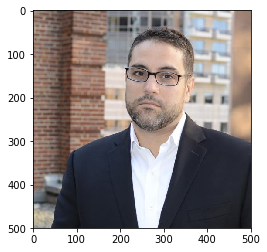

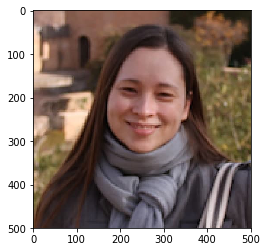

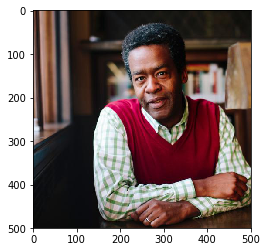

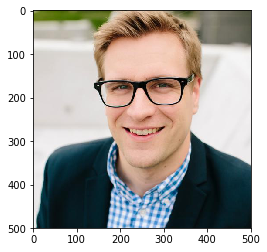

In [11]:
plot_image(faculty_4photo, faculty_file)

## 1.2 Plot the First 4 of Student Photo

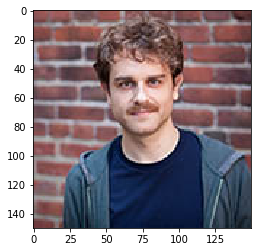

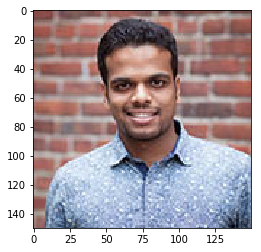

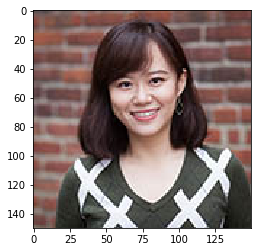

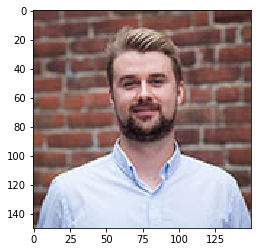

In [12]:
plot_image(student_4photo, student_file)

# 2.
Align the faces using some (I don’t mind which) image registration method. 

In [14]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
fa = FaceAligner(predictor, desiredFaceWidth=256)

faculty_imgs = [cv2.imread(f) for f in glob.glob("/Users/shen/Desktop/USF/MSAN628CS/hw/photos/faculty/*.jpg")]
faculty_imgs_aligned = []
m = 1
for img in faculty_imgs:
    image = imutils.resize(img, width=256)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    rect = detector(gray, 2)[0]
    
    (x, y, w, h) = rect_to_bb(rect)
    faceOrig = imutils.resize(image[y:y + h, x:x + w], width=256)
    faceAligned = fa.align(image,gray, rect)
    folder = 'faculty_new/'
    
    cv2.imwrite(path+folder + str(m)+'.jpg', faceAligned)
    m += 1

    faculty_imgs_aligned.append(faceAligned)

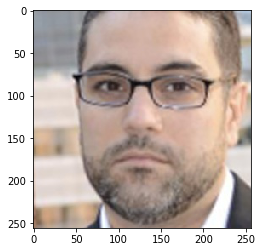

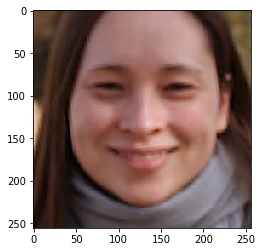

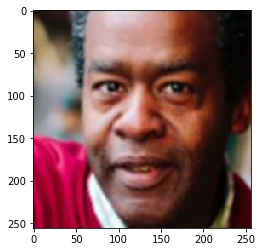

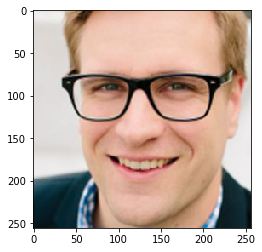

In [15]:
faculty_4photo_new = [str(a)+'.jpg' for a in range(1,5)]
student_4photo_new = [str(a)+'.jpg' for a in range(1,5)]

plot_image(faculty_4photo_new, 'faculty_new/')

In [16]:
student_imgs = [cv2.imread(f) for f in glob.glob("/Users/shen/Desktop/USF/MSAN628CS/hw/photos/student/*.jpg")]

# align student photos
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
fa = FaceAligner(predictor, desiredFaceWidth=256)

student_imgs_aligned = []
m = 1
for img in student_imgs:
    image = imutils.resize(img, width=256)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    rect = detector(gray, 2)[0]
    
    (x, y, w, h) = rect_to_bb(rect)
    faceOrig = imutils.resize(image[y:y + h, x:x + w], width=256)
    faceAligned = fa.align(image,gray, rect)
    folder = 'student_new/'
    
    cv2.imwrite(path+folder + str(m)+'.jpg', faceAligned)
    m += 1

    student_imgs_aligned.append(faceAligned)

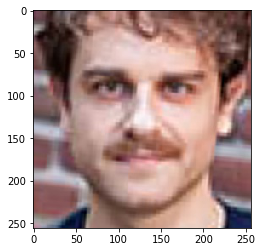

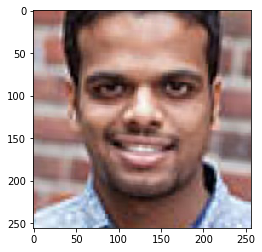

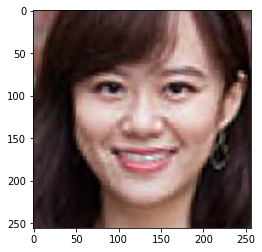

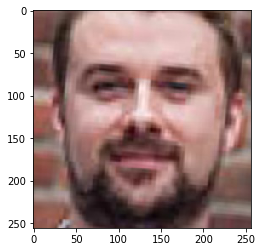

In [17]:
plot_image(student_4photo_new, 'student_new/')

# 3.
Perform the PCA analysis from the “eigen-faces” example for the faculty and students, separately. Identify the four most important “eigen-faces” for each group. What proportion of the variability do these faces make up for each group?

In [18]:
student_photo_paths = [f for f in glob.glob("/Users/shen/Desktop/USF/MSAN628CS/hw/photos/student_new/*.jpg")]
faculty_photo_paths = [f for f in glob.glob("/Users/shen/Desktop/USF/MSAN628CS/hw/photos/faculty_new/*.jpg")]

## 3.1 Students' Eigen-faces

In [19]:
image_size = cv2.imread(student_photo_paths[0],0).shape
student_no = len(student_photo_paths)
faculty_no = len(faculty_photo_paths)
student_matrix = np.zeros((student_no, image_size[0]*image_size[1]), dtype = np.float32)
faculty_matrix = np.zeros((faculty_no, image_size[0]*image_size[1]),dtype = np.float32)

In [21]:
student_image_list = []
for i in range(student_no):
    img = cv2.imread(student_photo_paths[i],0).astype('uint8')
    img = img.flatten()
    student_image_list.append(img)
    student_matrix[i,:] = img    

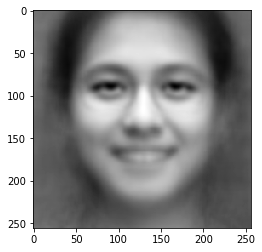

In [22]:
s_mean_vec = np.mean(student_matrix, axis =0)
s_mean_img = s_mean_vec.reshape(image_size)

# student average
plt.imshow(s_mean_img,cmap='gray')
plt.show()

### 3.1.1 Plot students' Eigen-faces

In [23]:
student_submean_matrix = student_matrix - s_mean_vec
student_pca = decomposition.PCA(n_components=10)
student_weight = student_pca.fit_transform(student_submean_matrix)

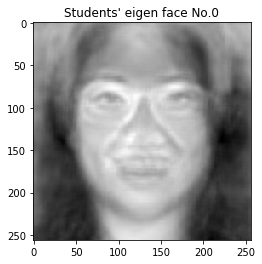

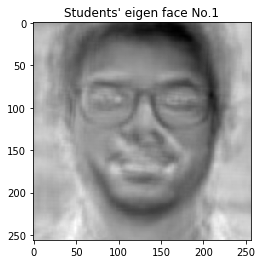

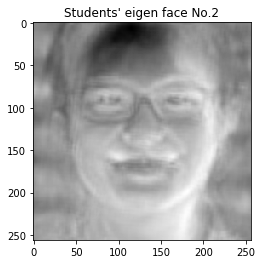

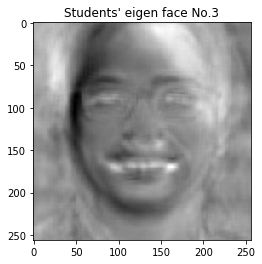

In [24]:
eigen_vector_s = student_pca.components_
for i in range(4):
    plt.imshow(eigen_vector_s[i].reshape(image_size),cmap='gray')
    plt.title('Students\' eigen face No.%d'% i )
    plt.show()

### 3.1.2 Proportion of the variability these faces make up for student

In [25]:
print ('These faces make up for student with a proportion of %.4f' %student_pca.explained_variance_ratio_.sum())

These faces make up for student with a proportion of 0.6496


## 3.2 Faculty's Eigen-faces

In [26]:
for i in range(faculty_no):
    img = cv2.imread(faculty_photo_paths[i],0).astype('uint8')
    img = img.flatten()
    faculty_matrix[i,:] = img    

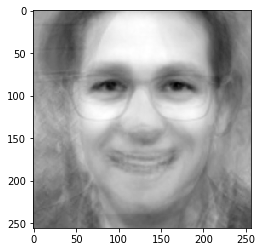

In [27]:
f_mean_vec = np.mean(faculty_matrix, axis =0)
f_mean_img = f_mean_vec.reshape(image_size)

# student average
plt.imshow(f_mean_img,cmap='gray')
plt.show()

### 3.2.1 Plot Faculty's Eigen-faces

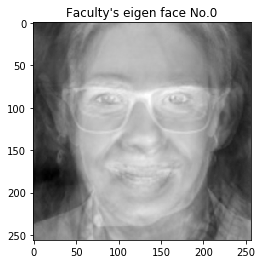

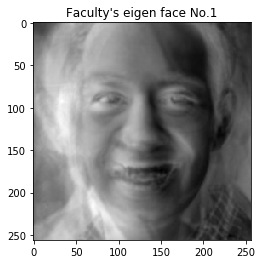

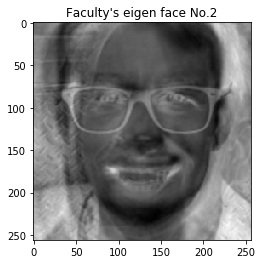

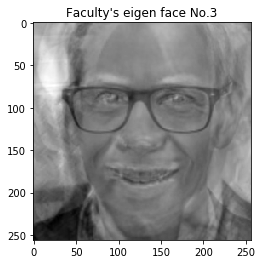

In [28]:
faculty_submean_matrix = faculty_matrix - f_mean_vec
f_pca = decomposition.PCA(n_components=10)
f_weight = f_pca.fit_transform(faculty_submean_matrix)
eigen_vector_f = f_pca.components_

for i in range(4):
    plt.imshow(eigen_vector_f[i].reshape(image_size),cmap='gray')
    plt.title('Faculty\'s eigen face No.%d' % i)
    plt.show()

### 3.1.2 Proportion of the variability these faces make up for faculty

In [29]:
print ('These faces make up for faculty with a proporty of %.4f' % f_pca.explained_variance_ratio_.sum())

These faces make up for faculty with a proporty of 0.9317


# 4. 
Take your image from the student collection. What linear combination of the “eigen-faces” are you in the student group? Repeat this for my image from the faculty group.

## 4.1 My linear combination

In [30]:
student_weight[36]

array([-3199.22827148,  5752.00097656,  3864.60644531, -3552.26806641,
         109.90866852,   512.60784912, -4111.171875  ,  -150.28607178,
         230.92442322, -2190.7980957 ], dtype=float32)

## 4.2 James's linear combination

In [31]:
f_weight[11]

array([-5271.53320312, -9372.61035156,  9170.8828125 , -1449.32531738,
         350.22512817,  -857.61407471,  -946.36358643, -3481.92382812,
        1196.29382324, -3577.35327148], dtype=float32)

# 5.
Consider the task of determining the similarity between the faces of the faculty and the students. Using the PCA analysis above, how can you measure similarity between these two collections? Using your similarity metric, create a similarity graph between all students and faculty and identify which image my image is most similar to. Create and visualize a similarity graph that illustrates the similarity among students and faculty using some combination of edge weights and thresholding.

## 5.1 Compute the weights of nodes by PCA

In [32]:
whole_matrix = np.vstack((student_matrix, faculty_matrix))

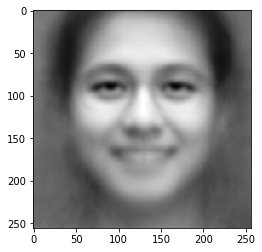

In [33]:
w_mean_vec = np.mean(whole_matrix, axis = 0)
w_mean_img = w_mean_vec.reshape(image_size)

# all average
plt.imshow(w_mean_img,cmap='gray')
plt.show()

In [34]:
w_submean_matrix = whole_matrix - w_mean_vec
w_pca = decomposition.PCA(n_components=10)

# compute the weights of every person in the group
w_weight = w_pca.fit_transform(w_submean_matrix)

## 5.2 Compute similarity by distance

In [35]:
# build similar metrix formula
def similar_metrix(guest, host):
    
    # the distance of two persons' weights
    return ((guest - host)**2).sum()

In [43]:
# build an empty similarity matrix
all_id = [a for a in range(len(w_weight))]
distance_matrix = np.zeros((len(w_weight), len(w_weight)), dtype = np.float32)

In [58]:
for i in all_id:
    host = w_weight[i]
    host_distance_list = []
    for n in all_id:
        guest = w_weight[n]
        
        # compute the distance of two nodes and log transformation
        distance_in = similar_metrix(guest, host)
        distance_im = np.log10(distance_in + .00000000000000001)
        host_distance_list.append(distance_im)
    distance_matrix[i,:] = np.array(host_distance_list)

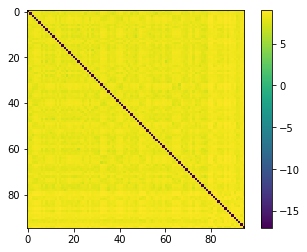

In [140]:
plt.imshow(distance_matrix)
plt.colorbar()
plt.show()

## 5.3 Build network dataframe

In [59]:
# build an empty datafram for network information
nodes_df = pd.DataFrame(index = [a for a in range(len(w_weight)*(len(w_weight)-1))], columns=['from','to','weight','connection'])

define the threshold of connection

In [87]:
m = 0

# assume the threshold 
threshold = 7.4

for i in range(len(w_weight)):
    for n in range(len(w_weight)):
        if n > i:
            nodes_df['from'][m] = i
            nodes_df['to'][m] = n
            
            # define the weight of connection
            nodes_df['weight'][m] = distance_matrix[i,n]
            
            if distance_matrix[i,n] != -17 :
                nodes_df['connection'][m] = 1 if distance_matrix[i,n] < threshold else 0
            else: nodes_df['connection'][m] = -1
            m += 1

In [89]:
selected_nodes = nodes_df[nodes_df.connection == 1]

In [126]:
# select james connection
james_nodes_from = nodes_df[nodes_df.to == 90]
james_node_to = nodes_df[nodes_df['from'] == 90]

frames = [selected_nodes, james_nodes_from, james_node_to]
combined_df = pd.concat(frames)

In [138]:
combined_df.head()

,from,to,weight,connection
10,0,11,7.29553,1
46,0,47,7.37569,1
117,1,25,7.39608,1
137,1,45,7.38133,1
148,1,56,7.29782,1


### 5.4 Plot the network

In [128]:
G=nx.Graph()

for i in range(len(combined_df)):
    G.add_edge(str(combined_df['from'].iloc[i]),str(combined_df['to'].iloc[i]),weight=combined_df['weight'].iloc[i])

#### 5.4.1 The class network

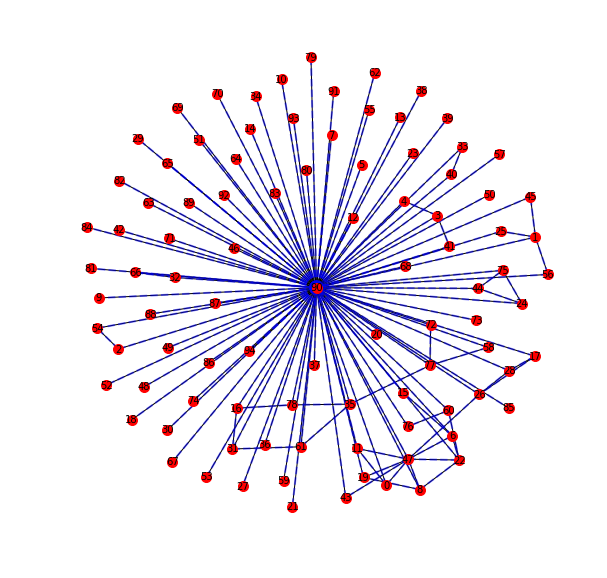

In [129]:
pos=nx.spring_layout(G) # positions for all nodes
plt.figure(figsize=(10,10))
# nodes
nx.draw_networkx_nodes(G,pos,node_size=100)

# edges
nx.draw_networkx_edges(G,pos,#edgelist=elarge,
                    width=1)
nx.draw_networkx_edges(G,pos,#edgelist=esmall,
                    width=2,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=10,font_family='sans-serif')

plt.axis('off')
# plt.savefig("weighted_graph.png") # save as png
plt.show() # display

### 5.4.2 The similarest person of James

In [135]:
james_nodes_from[james_nodes_from.weight < 8]

,from,to,weight,connection
4355,79,90,7.95087,0


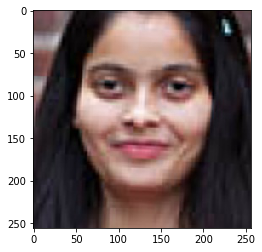

In [137]:
plot_image(['79.jpg'], 'student_new/')